<a href="https://colab.research.google.com/github/Taejin1221/Lab_Experiment/blob/main/Trajectory_Clustering/Trajectory_Clustering_16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import modules

In [1]:
import os, cv2, glob
import numpy as np
import pandas as pd

'''
If you want to know this file,
refer to https://github.com/smupilab/Trajectory-AE/blob/master/utils/convertImage.py
'''
import convertImage as utils
import matplotlib.pyplot as plt

# Set Constants

In [2]:
# Constants
WIDTH, HEIGHT = 256, 256
CROP_WIDTH, CROP_HEIGHT = 32, 32
CROP_IMAGE_NUMBER = (WIDTH // CROP_WIDTH) * (HEIGHT // CROP_HEIGHT)
print( 'Crop image number:', CROP_IMAGE_NUMBER )

EXPERIMENT_DATA = {
    'name' : 'Trajectory_Clusetring',
    'number' : '18',
    'date' : '06-03-2021',
    'description' : '유사 경로 검색 구현 with All Geolife data\n'
    }

if ( 'Results' not in os.listdir() ):
    os.mkdir( 'Results' )

ROOT_DIR = os.getcwd()
DATA_DIR = os.path.join( ROOT_DIR, 'Data')
RESULT_DIR = os.path.join( ROOT_DIR, 'Results')

plt.gray()

Crop image number: 64


<Figure size 432x288 with 0 Axes>

# Load and Preprocessing Data

## Convert CSV to Image

In [3]:
os.chdir( DATA_DIR )

original_images = [ ]
generator = utils.Map2ImageGenerator( WIDTH, HEIGHT, 0 )

for directory in sorted(os.listdir()):
    if ( directory == '.DS_Store' ):
        continue

    print( directory )
    
    os.chdir( os.path.join( DATA_DIR, directory, 'Trajectory' ) )
    files = glob.glob( '*plt' )

    for i, file in enumerate(files):
        csv_file = pd.read_csv( file, names = [ 'lat', 'long', 'zero', 'alti', 'date_number', 'date_string', 'time'  ] )[6:]
        csv_file.index = range( 0, len( csv_file ) )
        original_images.append( generator.ConvertImage( csv_file ) )

print( 'Total number of trajectories:', len( original_images ) )

000
001
002
003
004
005
006
007
008
009
010
011
012
013
014
015
016
017
018
019
020
021
022
023
024
025
026
027
028
029
030
031
032
033
034
035
036
037
038
039
040
041
042
043
044
045
046
047
048
049
050
051
052
053
054
055
056
057
058
059
060
061
062
063
064
065
066
067
068
069
070
071
072
073
074
075
076
077
078
079
080
081
082
083
084
085
086
087
088
089
090
091
092
093
094
095
096
097
098
099
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
Total number of trajectories: 18670


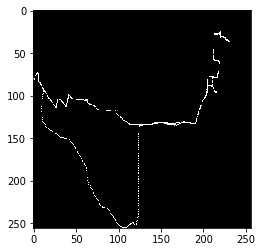

In [4]:
plt.imshow( original_images[0] )
plt.show()

## Crop Image

In [ ]:
cropped_images_train, matching = [ ], [ ]
for image in original_images:
    matching.append( len( cropped_images_train ) )
    for i in range( 0, HEIGHT, CROP_HEIGHT ):
        for j in range( 0, WIDTH, CROP_WIDTH ):
            curr_image = [ ]
            for ii in range( i, i + CROP_HEIGHT ):
                curr_image.append( image[ii][j : j + CROP_WIDTH] )
            cropped_images_train.append( curr_image )

In [ ]:
row, col = HEIGHT // CROP_HEIGHT, WIDTH // CROP_WIDTH
fig, ax = plt.subplots( row, col, True, True, figsize = ( 64, 64 ) )
for i in range( row * col ):
    ax[i // row][i % col].imshow( cropped_images_train[i] )
plt.show()

In [ ]:
print( len(cropped_images_train) )

In [ ]:
X_train = np.array( cropped_images_train ).astype( 'float32' ) / 255.
X_train = np.reshape( X_train, ( -1, CROP_HEIGHT, CROP_WIDTH, 1 ) )

In [ ]:
print( X_train.shape )

# Construct AE Model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
af, pd = 'relu', 'same' # activation function and padding value

encode_input = layers.Input( ( CROP_HEIGHT, CROP_WIDTH, 1 ) )
x = layers.Conv2D( 32, ( 3, 3 ), activation = af, padding = pd )( encode_input )
x = layers.MaxPooling2D( ( 2, 2 ), padding = pd )( x )

x = layers.Conv2D( 32, ( 3, 3 ), activation = af, padding = pd )( x )
x = layers.MaxPooling2D( ( 2, 2 ), padding = pd )( x )

x = layers.Conv2D( 16, ( 3, 3 ), activation = af, padding = pd )( x )
x = layers.MaxPooling2D( ( 2, 2 ), padding = pd )( x )

x = layers.Conv2D( 16, ( 3, 3 ), activation = af, padding = pd )( x )
x = layers.MaxPooling2D( ( 2, 2 ), padding = pd )( x )

feature_map_shape = x.shape
flatten_size = feature_map_shape[1] * feature_map_shape[2] * feature_map_shape[3]

x = layers.Flatten()( x )
encode_output = layers.Dense( flatten_size , activation = af )( x )

In [ ]:
encoder = keras.Model( encode_input, encode_output, name = 'Encoder' )
encoder.summary()

In [ ]:
decode_input = layers.Input( ( flatten_size ) )

x = layers.Dense( flatten_size, activation = af )( decode_input )
x = layers.Reshape( feature_map_shape[1:] )( x )

x = layers.Conv2DTranspose( 16, ( 3, 3 ), activation = af, padding = pd )( x )
x = layers.UpSampling2D( ( 2, 2 ) )( x )

x = layers.Conv2DTranspose( 16, ( 3, 3 ), activation = af, padding = pd )( x )
x = layers.UpSampling2D( ( 2, 2 ) )( x )

x = layers.Conv2DTranspose( 32, ( 3, 3 ), activation = af, padding = pd )( x )
x = layers.UpSampling2D( ( 2, 2 ) )( x )

x = layers.Conv2DTranspose( 32, ( 3, 3 ), activation = af, padding = pd )( x )
x = layers.UpSampling2D( ( 2, 2 ) )( x )

decode_output = layers.Conv2DTranspose( 1, ( 3, 3 ), activation = af, padding = pd )( x )

In [ ]:
decoder = keras.Model( decode_input, decode_output, name = 'Decoder' )
decoder.summary()

In [ ]:
auto_encoder = keras.Model( encode_input, decoder( encoder( encode_input ) ), name = 'Auto_Encoder' )
auto_encoder.summary()

# Traing Model

In [ ]:
LAMBDA1, LAMBDA2 = 0.15, 0.85

def SSIM_Loss( y_true, y_pred ):
    ssim = tf.image.ssim( y_true, y_pred, max_val = 1.0, filter_size = 11,
                          filter_sigma = 1.5, k1 = 0.01, k2 = 0.03)
    
    return 1 - tf.reduce_mean( ssim )

def Hybrid_Loss( y_true, y_pred ):
    f1 = keras.losses.MAE( y_true, y_pred )
    f2 = SSIM_Loss( y_true, y_pred )

    return LAMBDA1 * f1 + LAMBDA2 * f2

# auto_encoder.compile( 'adam', loss = Hybrid_Loss )
auto_encoder.compile( 'adam', loss = 'mse' )

In [ ]:
EPOCH = 300
BATCH = 128

In [ ]:
history = auto_encoder.fit( X_train, X_train, epochs = EPOCH, batch_size = BATCH  )

# Test Model

In [ ]:
os.chdir( RESULT_DIR )

new_result_dir = f"{EXPERIMENT_DATA['name']}_{EXPERIMENT_DATA['number']}_{EXPERIMENT_DATA['date']}_Datas"
os.mkdir( new_result_dir )
os.chdir( new_result_dir )

with open( 'Description.txt', 'w' ) as f:
    f.write( EXPERIMENT_DATA['description'] )

## Check Reconstruction

In [ ]:
decoded_img = auto_encoder( X_train )

plt.gray()

row, col = HEIGHT // CROP_HEIGHT, WIDTH // CROP_WIDTH
n = row * col
fig, ax = plt.subplots( row, 2 * col, True, True, figsize = ( 64, 32 ) )
for i in range( n ):
    ax[i // 8][i % 8].imshow( X_train[i].reshape( CROP_HEIGHT, CROP_WIDTH ) )
    ax[i // 8][i % 8 + 8].imshow( tf.reshape( decoded_img[i], ( CROP_HEIGHT, CROP_WIDTH ) ) )

result_name = (EXPERIMENT_DATA['name'] + '_'
    + EXPERIMENT_DATA['number'] + '_'
    + 'Reconstruction' + '('
    + EXPERIMENT_DATA['date'] + ').png')
print( result_name )

plt.savefig( result_name, dpi = 100 )
plt.show()

## Calculate Cosine Similarity

In [ ]:
# Cosine Similarity
from scipy.spatial import distance

thresholds = [ 0.15, 0.2, 0.25, 0.3 ]
low_dimension_data = encoder( X_train )

In [ ]:
for threshold in thresholds:
    same_trajectory_idx = [ 0 ]

    for compare_idx in range( 1, len( X_train ) // CROP_IMAGE_NUMBER ):
        cnt = 0
        for i, j in zip( range( 0, 64 ), range( compare_idx * CROP_IMAGE_NUMBER, (compare_idx + 1) * CROP_IMAGE_NUMBER ) ):
            dist = distance.cosine( low_dimension_data[i], low_dimension_data[j] )
            if ( dist < threshold ):
                cnt += 1

        if ( cnt > 50 ):
            same_trajectory_idx.append( compare_idx )
    
    origin_X_train = X_train.reshape( -1, CROP_HEIGHT, CROP_WIDTH )

    one_image = [ [ 0 for _ in range( WIDTH ) ] for _ in range( HEIGHT ) ]
    stack_image = [ [ 0 for _ in range( WIDTH ) ] for _ in range( HEIGHT ) ]

    for idx in same_trajectory_idx:
        for idx64 in range( idx * CROP_IMAGE_NUMBER, (idx + 1) * CROP_IMAGE_NUMBER ):
            image = origin_X_train[idx64]
            for i in range( CROP_HEIGHT ):
                for j in range( CROP_WIDTH ):
                    if ( image[i][j] > 0 ):
                        converted_row = ((idx64 % CROP_IMAGE_NUMBER) // 8) * CROP_HEIGHT + i
                        converted_col = ((idx64 % CROP_IMAGE_NUMBER) % 8) * CROP_WIDTH + j
                        one_image[converted_row][converted_col] = 255
                        stack_image[converted_row][converted_col] += 1
    
    print( f'Similar path number(thre:{threshold:.2f}):', len( same_trajectory_idx ) )
    
    plt.gray()
    plt.imshow( one_image )

    plt.savefig( f'Search_Result_{threshold:.2f}.png', dpi = 100 )
    plt.show()

In [ ]:
for idx in same_trajectory_idx:
    plt.imshow( original_images[idx] )
    plt.show()

In [ ]:
os.chdir( DATA_DIR )
if ( 'Image_Files' not in os.listdir() ):
    os.mkdir( 'Image_Files' )
os.chdir( 'Image_Files' )

num = 0
for img in original_images:
    cv2.imwrite( f'Geolife_trajectory{num}.png', img )
    
    num += 1